In [45]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [46]:
import pandas_datareader.data as web

In [59]:
#Getting the Data
start = datetime.datetime(2011, 11, 19)
end = datetime.datetime(2021, 11, 19)

In [60]:
AAPL = web.DataReader("AAPL", 'yahoo', start, end)

In [61]:
AAPL.drop(columns = 'Adj Close', inplace = True)
AAPL.head()

,High,Low,Open,Close,Volume
Date,,,,,
2011-11-21,13.274286,13.068214,13.228571,13.178929,447980400.0
2011-11-22,13.497500,13.247857,13.250714,13.446786,409021200.0
2011-11-23,13.422857,13.102857,13.375357,13.106786,428271200.0
2011-11-25,13.255357,12.975714,13.157857,12.984643,254760800.0
2011-11-28,13.454286,13.226071,13.298214,13.432857,346413200.0


In [62]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

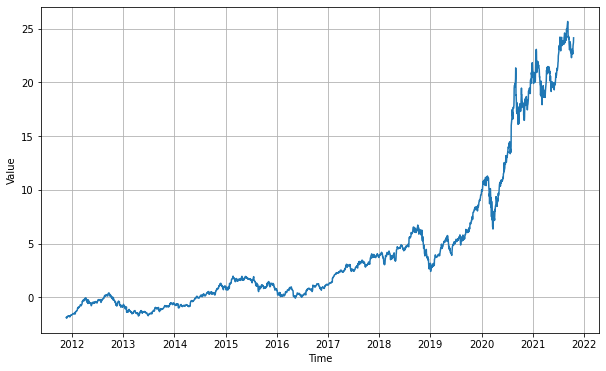

In [63]:
series = AAPL['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(AAPL.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [64]:
len(series)

2494

In [65]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 64
shuffle_buffer_size = 1000

In [66]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [77]:
tf.keras.backend.clear_session()

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
16/16 [==============================] - 3s 23ms/step - loss: 4.1238 - mae: 4.6029
Epoch 2/100
16/16 [==============================] - 0s 21ms/step - loss: 4.0862 - mae: 4.5640
Epoch 3/100
16/16 [==============================] - 0s 21ms/step - loss: 4.0356 - mae: 4.5113
Epoch 4/100
16/16 [==============================] - 0s 21ms/step - loss: 3.9780 - mae: 4.4512
Epoch 5/100
16/16 [==============================] - 0s 23ms/step - loss: 3.9141 - mae: 4.3837
Epoch 6/100
16/16 [==============================] - 0s 25ms/step - loss: 3.8442 - mae: 4.3100
Epoch 7/100
16/16 [==============================] - 0s 21ms/step - loss: 3.7676 - mae: 4.2292
Epoch 8/100
16/16 [==============================] - 0s 21ms/step - loss: 3.6844 - mae: 4.1417
Epoch 9/100
16/16 [==============================] - 0s 21ms/step - loss: 3.5945 - mae: 4.0482
Epoch 10/100
16/16 [==============================] - 0s 26ms/step - loss: 3.4974 - mae: 3.9484
Epoch 11/100
16/16 [=============================

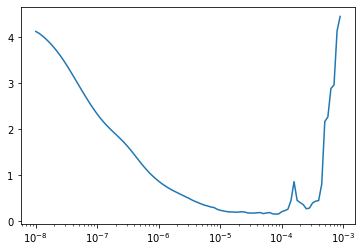

In [78]:
plt.semilogx(history.history["lr"], history.history["loss"])

In [79]:
tf.keras.backend.clear_session()
train_set = windowed_dataset(x_train, window_size, batch_size=250, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500)

Epoch 1/500
8/8 [==============================] - 3s 84ms/step - loss: 2.3265 - mae: 2.7782
Epoch 2/500
8/8 [==============================] - 1s 75ms/step - loss: 1.3790 - mae: 1.8206
Epoch 3/500
8/8 [==============================] - 1s 73ms/step - loss: 1.3444 - mae: 1.7918
Epoch 4/500
8/8 [==============================] - 1s 79ms/step - loss: 1.0659 - mae: 1.5076
Epoch 5/500
8/8 [==============================] - 1s 74ms/step - loss: 0.8392 - mae: 1.2705
Epoch 6/500
8/8 [==============================] - 1s 76ms/step - loss: 0.5369 - mae: 0.9279
Epoch 7/500
8/8 [==============================] - 1s 74ms/step - loss: 0.3962 - mae: 0.7570
Epoch 8/500
8/8 [==============================] - 1s 73ms/step - loss: 0.3041 - mae: 0.6062
Epoch 9/500
8/8 [==============================] - 1s 70ms/step - loss: 0.2895 - mae: 0.5976
Epoch 10/500
8/8 [==============================] - 1s 72ms/step - loss: 0.2790 - mae: 0.5785
Epoch 11/500
8/8 [==============================] - 1s 71ms/step - lo

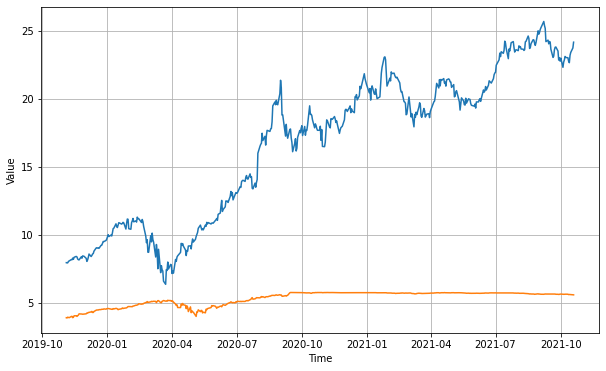

In [80]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [81]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

array([12.711606 , 12.729751 , 12.671535 , 12.6912565, 12.709865 ,
       12.621131 , 12.610558 , 12.707428 , 12.675151 , 12.569465 ,
       12.56862  , 12.613795 , 12.569125 , 12.517714 , 12.427338 ,
       12.432313 , 12.44037  , 12.454321 , 12.440956 , 12.424417 ,
       12.364916 , 12.37285  , 12.326783 , 12.321415 , 12.281378 ,
       12.24872  , 12.325307 , 12.325709 , 12.25254  , 12.161436 ,
       12.142059 , 12.146317 , 12.14505  , 12.119946 , 12.111849 ,
       12.088483 , 12.091196 , 12.062942 , 12.083515 , 12.048524 ,
       12.033623 , 12.042621 , 12.077316 , 12.09063  , 12.093232 ,
       12.041732 , 12.06496  , 12.025428 , 12.03196  , 12.066418 ,
       12.119717 , 12.093685 , 12.050533 , 11.99386  , 12.03562  ,
       12.018357 , 11.993203 , 11.985668 , 11.945712 , 11.895547 ,
       11.889751 , 11.896814 , 11.893861 , 11.899982 , 11.852229 ,
       11.849429 , 11.79164  , 11.792755 , 11.775391 , 11.754054 ,
       11.688178 , 11.716659 , 11.693516 , 11.707256 , 11.6604

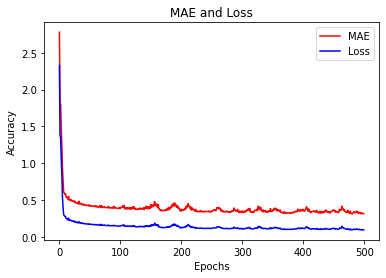

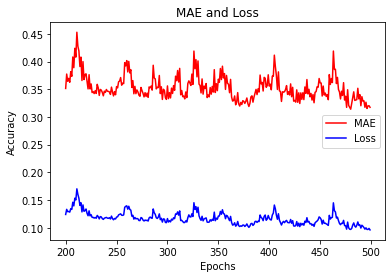

In [82]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])